# Introduction

These next few cells are Python to get set up with yodapy. First establish an account at the 
[OOI website](https://ooinet.oceanobservatories.org/#). 
Generate credentials, do not put them in a GitHub repo but 
keep them somewhere safe. Follow through these cells by un-commenting, running, and re-commenting so that 
you do not re-run them down the road when they are not necessary. 

In [5]:
# Ensure that yodapy is installed directly from github using
# !pip install git+https://github.com/cormorack/yodapy.git

In [9]:
# Run this line to prepare to set up your credentials to use the OOI
# from yodapy.utils.creds import set_credentials_file

In [32]:
# Run this by ***carefully**** substituting actual credentials in the username and token strings
# set_credentials_file(data_source='ooi', username='OOIAPI-XXXXXXXXXXXXXX', token='XXXXXXXXXXXX')

# And once it runs: Obscure your credentials as Xs and comment this out immediately; don't re-run it!

# You can verify this worked by examining the .credentials file in ~/.yodapy: Credentials should match. Notice that 
#   this (slightly hidden) directory is directly connected to your home directory; whereas this IPython notebook 
#   is presumed to exist in a distinct directory; so there should be no chance of a GitHub push sending your 
#   credentials to GitHub. 

AT a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the entire file... but dask works on lazy eval
so dask access to a parquet data ensemble (many of these small chunked files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is analogous to a 
pandas data frame with that virtualization. 


Athena in contrast is a way of doing something analogous. Athena is an AWS service running Apache Hive under the hood. 
You are charged for every query, be aware: And access protocol is a SQL query. 

# Create your ooi instance

The ooi instance will enable you to connect to data resources and get datasets. 

In [1]:
from yodapy.datasources import OOI

(MainThread) Please wait while we fetch the metadata ...


,RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample
0,Cabled Axial Seamount (Cabled Array)
1,Axial Base Shallow Profiler Mooring
2,Shallow Profiler (SF03A)
3,CTD
4,streamed
5,ctdpf_sbe43_sample


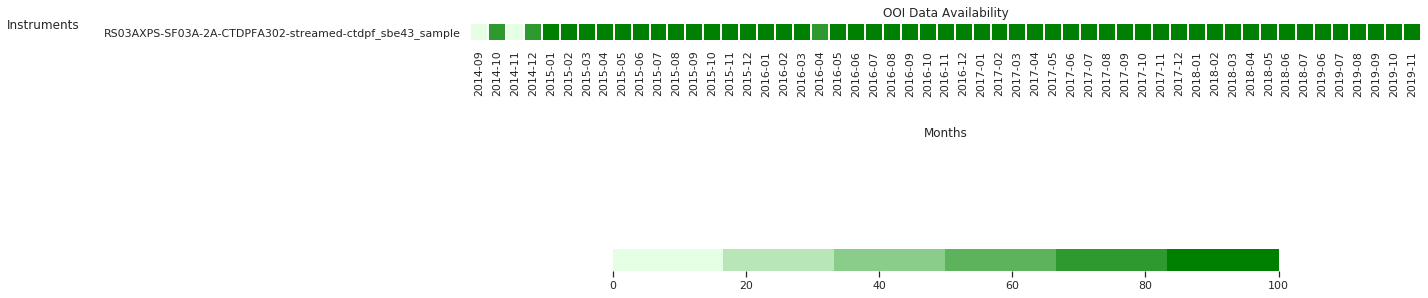

In [34]:
ooi = OOI()
ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
ooi.instruments                    # an attribute
ooi.data_availability()

In [57]:
# Let's move from this site to all of the others by getting all the site names
#   To see that use ooi.instruments (attribute) to see stuff only within the RCA
ooi.search(region='cabled')

<Data Source: OOI (116 Instrument Streams)>

In [36]:
ooi.sites                  # attribute, not method: ALL possible sites; but this is global exploration; not really a filter

,site_rd,array_name,site_name,description,min_depth,max_depth,longitude,latitude
0,CE01ISSM,Coastal Endurance,Oregon Inshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,25,-124.0950,44.6598
1,CE01ISSP,Coastal Endurance,Oregon Inshore Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,25,-124.0960,44.6620
2,CE02SHBP,Coastal Endurance,Oregon Shelf Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,79,79,-124.3060,44.6371
3,CE02SHSM,Coastal Endurance,Oregon Shelf Surface Mooring,A Surface Mooring is a type of mooring that co...,0,80,-124.3040,44.6393
4,CE02SHSP,Coastal Endurance,Oregon Shelf Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,81,-124.2990,44.6372
5,CE04OSBP,Coastal Endurance,Oregon Offshore Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,579,579,-124.9540,44.3695
6,CE04OSPD,Coastal Endurance,Oregon Offshore Cabled Deep Profiler Mooring,Profiler Moorings are a type of mooring that c...,175,576,-124.9530,44.3683
7,CE04OSPS,Coastal Endurance,Oregon Offshore Cabled Shallow Profiler Mooring,Profiler Moorings are a type of mooring that c...,20,588,-124.9560,44.3741
8,CE04OSSM,Coastal Endurance,Oregon Offshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,588,-124.9560,44.3811
10,CE06ISSM,Coastal Endurance,Washington Inshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,29,-124.2720,47.1336


In [58]:
ooi.instruments

,array_name,site_name,infrastructure_name,instrument_name,stream_method,stream_rd
0,Cabled Axial Seamount (Cabled Array),ASHES Vent Field,Medium-Power JBox (MJ03B),Bottom Pressure and Tilt,streamed,botpt_lily_sample
1,Cabled Axial Seamount (Cabled Array),ASHES Vent Field,Medium-Power JBox (MJ03B),Bottom Pressure and Tilt,streamed,botpt_iris_sample
2,Cabled Axial Seamount (Cabled Array),ASHES Vent Field,Medium-Power JBox (MJ03B),Bottom Pressure and Tilt,streamed,botpt_nano_sample_15s
3,Cabled Axial Seamount (Cabled Array),ASHES Vent Field,Medium-Power JBox (MJ03B),Bottom Pressure and Tilt,streamed,botpt_nano_sample
4,Cabled Axial Seamount (Cabled Array),ASHES Vent Field,Medium-Power JBox (MJ03B),Bottom Pressure and Tilt,streamed,botpt_nano_sample_24hr
...,...,...,...,...,...,...
111,Cabled Continental Margin (Cabled Array),Oregon Slope Base Shallow Profiler Mooring,Shallow Profiler (SF01A),pCO2 Water,streamed,pco2w_a_sami_data_record
112,Cabled Continental Margin (Cabled Array),Southern Hydrate Summit 1 Seafloor,Low-Power JBox (LJ01B),3-D Single Point Velocity Meter,streamed,vel3d_b_sample
113,Cabled Continental Margin (Cabled Array),Southern Hydrate Summit 1 Seafloor,Low-Power JBox (LJ01B),Tidal Seafloor Pressure,streamed,prest_real_time
114,Cabled Continental Margin (Cabled Array),Southern Hydrate Summit 2 Seafloor,Medium-Power JBox (MJ01B),Velocity Profiler (75 kHz),streamed,adcp_pd0_beam_parsed


(MainThread) Please wait while we fetch the metadata ...


,RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample
0,Cabled Axial Seamount (Cabled Array)
1,Axial Base Shallow Profiler Mooring
2,Shallow Profiler (SF03A)
3,CTD
4,streamed
5,ctdpf_sbe43_sample


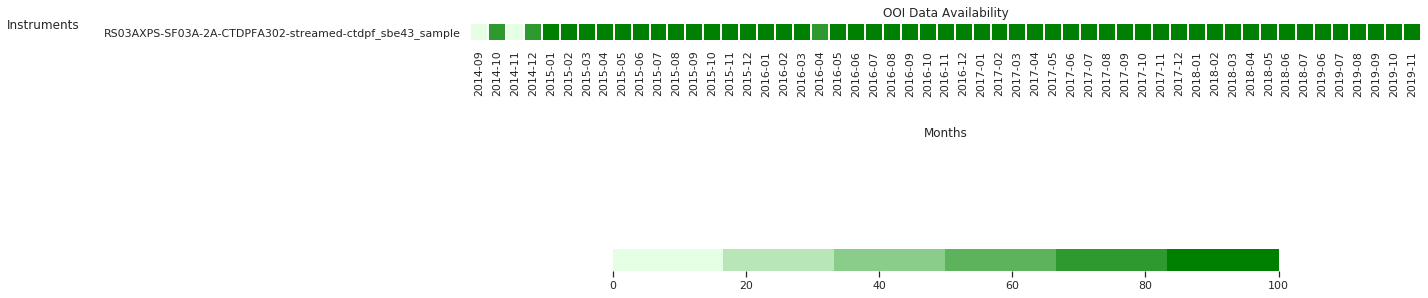

In [37]:
# Reprising an earlier cell let's go for CTD data (don't re-run this first line (kilroy) because that was done earlier)
ooi = OOI()
ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
ooi.instruments                    # an attribute
ooi.data_availability()

In [38]:
begin_date = '2018-01-01'
end_date = '2018-01-02'
ooi.request_data(begin_date=begin_date, end_date=end_date)

<Data Source: OOI (1 Instrument Stream)>

In [52]:
# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
ooi.check_status()

(MainThread) Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T220916352Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample) completed.


Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T220916352Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample) completed.


['https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20191114T220916352Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html']

In [53]:
ds = ooi.to_xarray()

(MainThread) Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T220916352Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample) completed.


Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T220916352Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample) completed.


(MainThread) Acquiring data from opendap urls ...
/srv/conda/envs/notebook/lib/python3.7/site-packages/yodapy/utils/conn.py:159: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  return xr.open_mfdataset(filt_ds, engine="netcdf4", **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,

In [54]:
ds[0]

<xarray.Dataset>
Dimensions:                                 (obs: 86398)
Coordinates:
  * obs                                     (obs) int32 0 1 2 ... 86396 86397
    time                                    (obs) datetime64[ns] dask.array<chunksize=(86398,), meta=np.ndarray>
    seawater_pressure                       (obs) float64 dask.array<chunksize=(86398,), meta=np.ndarray>
    lat                                     (obs) float64 dask.array<chunksize=(86398,), meta=np.ndarray>
    lon                                     (obs) float64 dask.array<chunksize=(86398,), meta=np.ndarray>
Data variables:
    deployment                              (obs) int32 dask.array<chunksize=(86398,), meta=np.ndarray>
    id                                      (obs) |S64 dask.array<chunksize=(86398,), meta=np.ndarray>
    conductivity                            (obs) float64 dask.array<chunksize=(86398,), meta=np.ndarray>
    driver_timestamp                        (obs) datetime64[ns] dask.array

In [61]:
# This will not work because OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
filenamelist = ooi.download_netcdfs()

(MainThread) Downloading netcdfs ...
(MainThread) Downloading deployment0004_RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample_20180101T000000.983558-20180101T235959.999175.nc...
(MainThread) Writing deployment0004_RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample_20180101T000000.983558-20180101T235959.999175.nc...
(MainThread) deployment0004_RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample_20180101T000000.983558-20180101T235959.999175.nc successfully downloaded ---
(MainThread) --- Checking deployment0004_RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample_20180101T000000.983558-20180101T235959.999175.nc ---
(MainThread) --- Checks passed for deployment0004_RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample_20180101T000000.983558-20180101T235959.999175.nc ---


In [62]:
print(len(filenamelist))

1


In [3]:
import xarray as xr

In [64]:
ooids = xr.open_dataset(filenamelist[0])              # or use open_mfdataset(filenamelist) but this can conflate types of data 

In [65]:
ooids

<xarray.Dataset>
Dimensions:                                 (obs: 86398)
Coordinates:
  * obs                                     (obs) int32 0 1 2 ... 86396 86397
    time                                    (obs) datetime64[ns] ...
    seawater_pressure                       (obs) float64 ...
    lat                                     (obs) float64 ...
    lon                                     (obs) float64 ...
Data variables:
    deployment                              (obs) int32 ...
    id                                      (obs) |S36 ...
    conductivity                            (obs) float64 ...
    driver_timestamp                        (obs) datetime64[ns] ...
    ext_volt0                               (obs) float64 ...
    ingestion_timestamp                     (obs) datetime64[ns] ...
    internal_timestamp                      (obs) datetime64[ns] ...
    port_timestamp                          (obs) datetime64[ns] ...
    preferred_timestamp                     (

,RS01SBPD-DP01A-03-FLCDRA102-recovered_inst-dpc_flcdrtd_instrument_recovered,RS01SBPD-DP01A-03-FLCDRA102-recovered_wfp-dpc_flcdrtd_instrument_recovered,RS03AXPD-DP03A-03-FLCDRA302-recovered_inst-dpc_flcdrtd_instrument_recovered,RS03AXPD-DP03A-03-FLCDRA302-recovered_wfp-dpc_flcdrtd_instrument_recovered,RS01SBPD-DP01A-04-FLNTUA102-recovered_inst-dpc_flnturtd_instrument_recovered,RS01SBPD-DP01A-04-FLNTUA102-recovered_wfp-dpc_flnturtd_instrument_recovered,RS03AXPD-DP03A-03-FLNTUA302-recovered_inst-dpc_flnturtd_instrument_recovered,RS03AXPD-DP03A-03-FLNTUA302-recovered_wfp-dpc_flnturtd_instrument_recovered,RS01SBPS-PC01A-4C-FLORDD103-streamed-flort_d_data_record,RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record,RS03AXPS-PC03A-4C-FLORDD303-streamed-flort_d_data_record,RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record
0,Cabled Continental Margin (Cabled Array),Cabled Continental Margin (Cabled Array),Cabled Axial Seamount (Cabled Array),Cabled Axial Seamount (Cabled Array),Cabled Continental Margin (Cabled Array),Cabled Continental Margin (Cabled Array),Cabled Axial Seamount (Cabled Array),Cabled Axial Seamount (Cabled Array),Cabled Continental Margin (Cabled Array),Cabled Continental Margin (Cabled Array),Cabled Axial Seamount (Cabled Array),Cabled Axial Seamount (Cabled Array)
1,Oregon Slope Base Deep Profiler Mooring,Oregon Slope Base Deep Profiler Mooring,Axial Base Deep Profiler Mooring,Axial Base Deep Profiler Mooring,Oregon Slope Base Deep Profiler Mooring,Oregon Slope Base Deep Profiler Mooring,Axial Base Deep Profiler Mooring,Axial Base Deep Profiler Mooring,Oregon Slope Base Shallow Profiler Mooring,Oregon Slope Base Shallow Profiler Mooring,Axial Base Shallow Profiler Mooring,Axial Base Shallow Profiler Mooring
2,Wire-Following Profiler (DP01A),Wire-Following Profiler (DP01A),Wire-Following Profiler (DP03A),Wire-Following Profiler (DP03A),Wire-Following Profiler (DP01A),Wire-Following Profiler (DP01A),Wire-Following Profiler (DP03A),Wire-Following Profiler (DP03A),200m Platform (PC01A),Shallow Profiler (SF01A),200m Platform (PC03A),Shallow Profiler (SF03A)
3,CDOM Fluorometer,CDOM Fluorometer,CDOM Fluorometer,CDOM Fluorometer,2-Wavelength Fluorometer,2-Wavelength Fluorometer,2-Wavelength Fluorometer,2-Wavelength Fluorometer,2-Wavelength Fluorometer,3-Wavelength Fluorometer,2-Wavelength Fluorometer,3-Wavelength Fluorometer
4,recovered_inst,recovered_wfp,recovered_inst,recovered_wfp,recovered_inst,recovered_wfp,recovered_inst,recovered_wfp,streamed,streamed,streamed,streamed
5,dpc_flcdrtd_instrument_recovered,dpc_flcdrtd_instrument_recovered,dpc_flcdrtd_instrument_recovered,dpc_flcdrtd_instrument_recovered,dpc_flnturtd_instrument_recovered,dpc_flnturtd_instrument_recovered,dpc_flnturtd_instrument_recovered,dpc_flnturtd_instrument_recovered,flort_d_data_record,flort_d_data_record,flort_d_data_record,flort_d_data_record


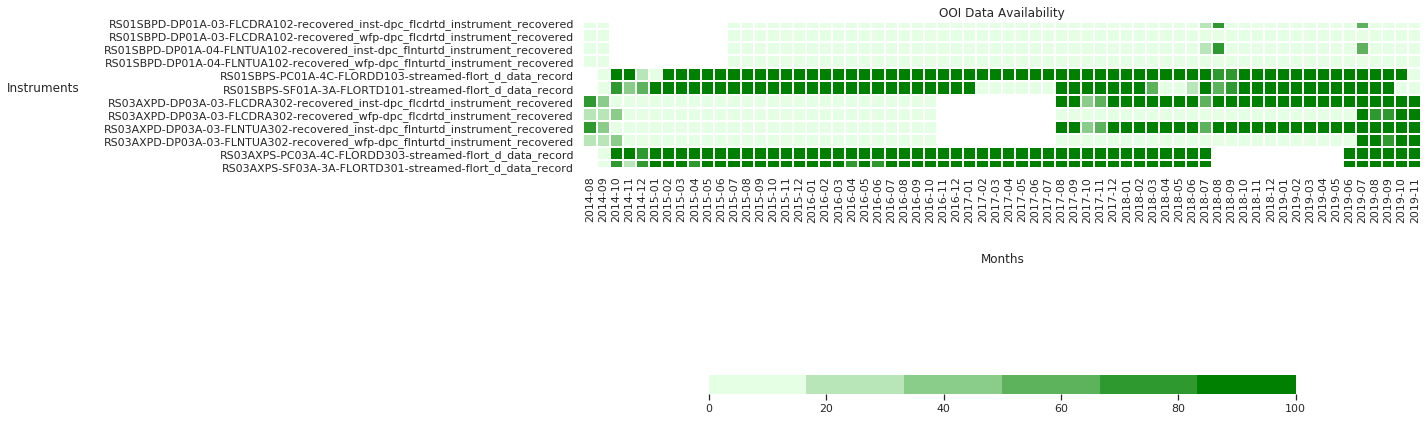

In [69]:
# re-do the search specific to chlorophyll: Notice the instruments value is a search term
ooi.search(region='cabled', instrument='fluorometer')
ooi.instruments                    # an attribute
ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers* and these are transposed in the subsequent data availability
#   graph into rows for the time series. 

,RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
0,Cabled Continental Margin (Cabled Array)
1,Oregon Slope Base Shallow Profiler Mooring
2,Shallow Profiler (SF01A)
3,3-Wavelength Fluorometer
4,streamed
5,flort_d_data_record


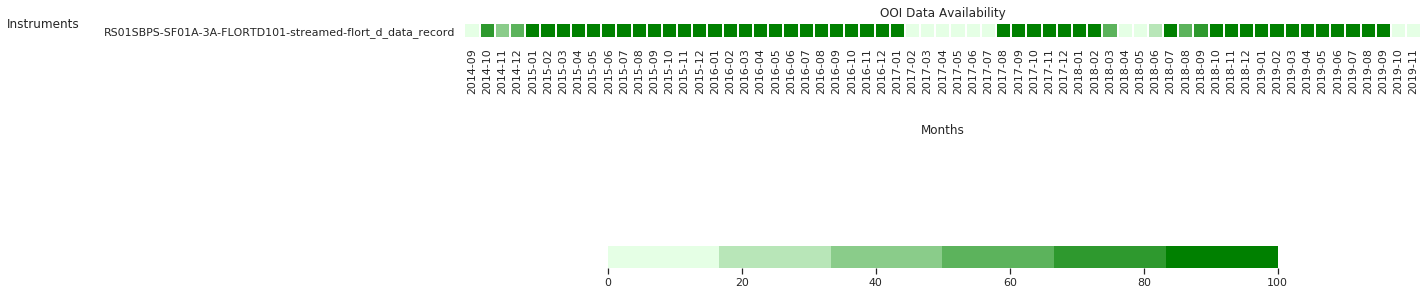

In [70]:
# Let's be specific to the Oregon Slope Base profiler
ooi.search(region='cabled', site = 'Oregon Slope Base', node = 'Shallow Profiler', instrument='fluorometer', )
ooi.instruments                    # an attribute
ooi.data_availability()

In [72]:
begin_date = '2019-06-01'
end_date = '2019-09-30'
ooi.request_data(begin_date=begin_date, end_date=end_date, time_check = False)

<Data Source: OOI (1 Instrument Stream)>

In [75]:
chlords = ooi.to_xarray()

(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 10s


Data request time elapsed: 10s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 20s


Data request time elapsed: 20s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 30s


Data request time elapsed: 30s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 41s


Data request time elapsed: 41s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 51s


Data request time elapsed: 51s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 61s


Data request time elapsed: 61s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 72s


Data request time elapsed: 72s


(MainThread) Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) completed.


Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191114T223806102Z-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record) completed.


(MainThread) Acquiring data from opendap urls ...
/srv/conda/envs/notebook/lib/python3.7/site-packages/yodapy/utils/conn.py:159: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  return xr.open_mfdataset(filt_ds, engine="netcdf4", **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,

In [76]:
filenamelist = ooi.download_netcdfs()

In [78]:
chlor = xr.open_mfdataset(filenamelist)
chlor

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:                                          (obs: 8121274)
Coordinates:
  * obs                                              (obs) int64 0 1 ... 775202
    time                                             (obs) datetime64[ns] dask.array<chunksize=(951585,), meta=np.ndarray>
    int_ctd_pressure                                 (obs) float64 dask.array<chunksize=(951585,), meta=np.ndarray>
    lat                                              (obs) float64 dask.array<chunksize=(951585,), meta=np.ndarray>
    lon                                              (obs) float64 dask.array<chunksize=(951585,), meta=np.ndarray>
Data variables:
    deployment                                       (obs) int32 dask.array<chunksize=(951585,), meta=np.ndarray>
    id                                               (obs) |S36 dask.array<chunksize=(951585,), meta=np.ndarray>
    date_string                                      (obs) object dask.array<chunksize=(951585,), meta=np.nd

In [77]:
# how many results came back? Remember OOI might chop up the data into contiguous time segments arbitrarily
len(filenamelist)

3

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


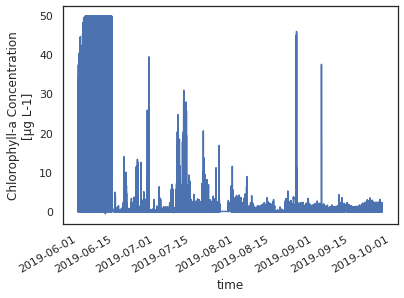

In [81]:
chlor = chlor.swap_dims({'obs':'time'})
chlor.fluorometric_chlorophyll_a.plot()

In [84]:
# Looking ahead; we need zarr...
# !pip install zarr

     |████████████████████████████████| 3.3MB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 43.5MB/s eta 0:00:01
  Created wheel for zarr: filename=zarr-2.3.2-cp37-none-any.whl size=127448 sha256=f4aca629052e9ffde5812980e5501fc2c48d74df441818c0fb883112d66ebe7f
  Stored in directory: /home/jovyan/.cache/pip/wheels/8d/6c/4b/82a896c388f0602858cabeb682acbdbb4f2254d44e570fd0cb
  Created wheel for asciitree: filename=asciitree-0.3.3-cp37-none-any.whl size=5036 sha256=a457bd8755ffa5a47595308bdd7883f7e7741d063774a98d5b2d85145435b93c
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
  Created wheel for numcodecs: filename=numcodecs-0.6.4-cp37-cp37m-linux_x86_64.whl size=4750843 sha256=9c263cd58b07ac275f1464f7bf020731766e02244c93421d67ed7ca94b5f29d2
  Stored in directory: /home/jovyan/.cache/pip/wheels/ca/07/ed/fea2e120cbb91d90b577c5ac56b4b082024f56fcd88e9afa55
Successfully built zarr asciitree numcodecs


In [4]:
# If this cell fails because you need zarr and it is not installed: See previous cell
# Looking ahead to zarr
import s3fs

cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)


In [5]:
s3ds

<xarray.Dataset>
Dimensions:                                          (time: 97705446)
Coordinates:
    int_ctd_pressure                                 (time) float64 dask.array<chunksize=(1048576,), meta=np.ndarray>
    lat                                              (time) float64 dask.array<chunksize=(1048576,), meta=np.ndarray>
    lon                                              (time) float64 dask.array<chunksize=(1048576,), meta=np.ndarray>
  * time                                             (time) datetime64[ns] 2014-10-06T14:10:13 ... 2019-09-27T18:41:51.008452096
Data variables:
    date_string                                      (time) <U1 dask.array<chunksize=(1048576,), meta=np.ndarray>
    deployment                                       (time) int32 dask.array<chunksize=(1048576,), meta=np.ndarray>
    driver_timestamp                                 (time) datetime64[ns] dask.array<chunksize=(1048576,), meta=np.ndarray>
    fluorometric_cdom                         

In [6]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

<xarray.Dataset>
Dimensions:                                          (time: 8121271)
Coordinates:
    int_ctd_pressure                                 (time) float64 dask.array<chunksize=(593361,), meta=np.ndarray>
    lat                                              (time) float64 dask.array<chunksize=(593361,), meta=np.ndarray>
    lon                                              (time) float64 dask.array<chunksize=(593361,), meta=np.ndarray>
  * time                                             (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-27T18:41:51.008452096
Data variables:
    date_string                                      (time) <U1 dask.array<chunksize=(593361,), meta=np.ndarray>
    deployment                                       (time) int32 dask.array<chunksize=(593361,), meta=np.ndarray>
    driver_timestamp                                 (time) datetime64[ns] dask.array<chunksize=(593361,), meta=np.ndarray>
    fluorometric_cdom                      

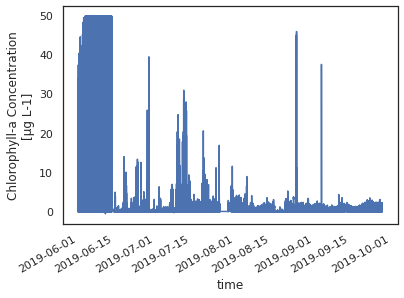

In [92]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [9]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.0s
